# APPNPÂÆüË£Ö

# APPNPÔºàApproximate Personalized Propagation of Neural PredictionsÔºâÂÆüË£Ö

ÂÖÉË´ñÊñáÔºöPredict then Propagate: Graph Neural Networks meet Personalized PageRank
Johannes Gasteiger, Aleksandar Bojchevski, Stephan G√ºnnemann
ICLR 2019

https://arxiv.org/abs/1810.05997
ÂèÇËÄÉ„Å´„Åó„Åü„É©„Ç§„Éñ„É©„É™ÔºöPyTorch Geometric

ÂÖ®‰Ωì„ÅÆÊµÅ„Çå

1.   „É©„Ç§„Éñ„É©„É™„ÅÆ„Ç§„É≥„Çπ„Éà„Éº„É´
2.   Ê±éÁî®Èñ¢Êï∞„ÅÆÂÆöÁæ©
3.   APPNP„É¢„Éá„É´ÂÆöÁæ©Ôºà2Â±§MLP + APPNP‰ºùÊí≠Ôºâ
4.   „Ç∞„É©„Éï„Éá„Éº„ÇøË™≠„ÅøËæº„ÅøÔºàPyTorch Geometric„Åß„Åã„ÇâË™≠„ÅøËæº„ÅøÔºâ
5.   Â≠¶ÁøíÊ∫ñÂÇô
6.   „É¢„Éá„É´Â≠¶ÁøíÔºàEarly Stopping‰ªò„ÅçÔºâ
7.   „ÉÜ„Çπ„ÉàÁ≤æÂ∫¶Ê§úË®º
8.   ÁµêÊûú„ÅÆÊèèÁîª


# „É©„Ç§„Éñ„É©„É™„ÅÆ„Ç§„É≥„Çπ„Éà„Éº„É´

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

# PyTorch Geometric„ÅØ‰Ωø„Çè„Åö„Å´„ÄÅÁã¨Ëá™„ÅßAPPNP„ÇíÂÆüË£Ö
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu124


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ê±éÁî®Èñ¢Êï∞„ÅÆÂÆöÁæ©

In [3]:
#‰π±Êï∞„ÅÆÂõ∫ÂÆöÂåñÔºàÊîπËâØÁâàÔºâ

def seed_everything(seed: int = 42):
    """
    Âü∫Êú¨ÁöÑ„Å™‰π±Êï∞Âõ∫ÂÆöÔºàËµ∑ÂãïÊôÇ„ÅÆ„Åø‰ΩøÁî®Ôºâ
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        # GPUÊé•Á∂öÁä∂ÊÖã„Çí„ÉÅ„Çß„ÉÉ„ÇØ„Åó„Å¶„Åã„ÇâCUDA‰π±Êï∞„ÇíË®≠ÂÆö
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

# „Ç∞„É≠„Éº„Éê„É´„Å´‰∏ÄÂ∫¶„Å†„ÅëÂÆüË°å
seed_everything(42)
print("ÂàùÊúü‰π±Êï∞Âõ∫ÂÆöÂÆå‰∫Ü")
print(f"CUDAÂà©Áî®ÂèØËÉΩ: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"‰ΩøÁî®GPU: {torch.cuda.get_device_name()}")

In [4]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # ÂêÑË°å„ÅÆ‰∏ÄÂàóÁõÆ„Å´Ê†ºÁ¥ç„Åï„Çå„Å¶„Çã„Éé„Éº„ÉâID„ÇíÊäΩÂá∫
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# ÂêÑË°å„ÅÆÊúÄÁµÇÂàó„Å´Ê†ºÁ¥ç„Åï„Çå„Å¶„Çã„É©„Éô„É´„ÇíÊäΩÂá∫Ôºé„Åì„ÅÆ„É©„Éô„É´„Åå‰∫àÊ∏¨„Çø„Éº„Ç≤„ÉÉ„Éà
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #ÂÆüÈöõ„ÅÆ„Éé„Éº„ÉâID„Çí0„Åã„ÇâÁØÄÁÇπÊï∞-1„Å´ÂØæÂøú‰ªò„Åë
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # ÂÆüÈöõ„ÅÆ„Éé„Éº„ÉâID„ÇíÂ§âÊèõ. reshape„Åß„Éá„Éº„ÇøÊßãÈÄ†„ÇíÂÖÉ„ÅÆÊûù„Éï„Ç°„Ç§„É´„Å®ÂêåÊßò„Å´Â§âÊõ¥Ôºé
    #print(edges)

    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    #print(adj)

    adj = adj + adj.T.multiply(adj.T > adj) #Èö£Êé•Ë°åÂàó„ÇíÂØæË±°„Å´Â§âÊõ¥ („Å§„Åæ„ÇäÔºåÁÑ°Âêë„Ç∞„É©„Éï„Å´Â§âÊèõ)
    #print(adj)

    adj = adj + sparse.eye(adj.shape[0]) #ÂØæËßíÊàêÂàÜ„Å´1„ÇíÊåøÂÖ•

    node_degrees = np.array(adj.sum(1)) #ÂàóÊØé„ÅÆÁ∑èÂíå„ÇíË®àÁÆó„Åô„ÇãÔºà„Å§„Åæ„ÇäÔºåÊ¨°Êï∞„ÇíË®àÁÆó„Åô„ÇãÔºâ
    #print(node_degrees)

    node_degrees = np.power(node_degrees, -0.5).flatten()
    #print(node_degrees)

    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)
    print(degree_matrix)

    adj = degree_matrix @ adj @ degree_matrix #Ë°åÂàó„ÅÆÁ©ç„ÇíË®àÁÆóÔºé
    #torch.spmm(degree_matrix,torch.spmm(adj,degree_matrix))

    print(adj)

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)
    adj = torch.FloatTensor(np.array(adj.todense()))

    return features, labels, adj, edges

In [5]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# APPNP„É¢„Éá„É´ÂÆöÁæ©

In [6]:
class APPNPNet(nn.Module):
    """
    APPNP„É¢„Éá„É´Ôºö2Â±§MLP„ÅßÂàùÊúüÁâπÂæ¥ÊäΩÂá∫ ‚Üí APPNP‰ºùÊí≠
    ÂæìÊù•„ÅÆÈö£Êé•Ë°åÂàó„Éô„Éº„Çπ„ÅÆÂÆüË£Ö
    """
    def __init__(self, num_features, hidden_dim, num_classes, K, alpha, dropout):
        super(APPNPNet, self).__init__()

        # 2Â±§MLPÔºàÁâπÂæ¥ÊäΩÂá∫Ôºâ
        self.mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

        # APPNP„Éë„É©„É°„Éº„Çø
        self.K = K
        self.alpha = alpha
        self.dropout = dropout

    def forward(self, x, adj):
        # 2Â±§MLP„ÅßÂàùÊúüÁâπÂæ¥ÊäΩÂá∫
        h0 = self.mlp(x)  # ÂàùÊúü‰∫àÊ∏¨ H0
        h = h0.clone()

        # APPNP‰ºùÊí≠ÔºöKÂõû„ÅÆ„Ç§„ÉÜ„É¨„Éº„Ç∑„Éß„É≥
        for k in range(self.K):
            # „Éâ„É≠„ÉÉ„Éó„Ç¢„Ç¶„ÉàÈÅ©Áî®ÔºàÂ≠¶ÁøíÊôÇ„ÅÆ„ÅøÔºâ
            if self.training:
                h = F.dropout(h, p=self.dropout, training=self.training)

            # ‰ºùÊí≠„Çπ„ÉÜ„ÉÉ„Éó: H(k+1) = (1-Œ±) * A_norm * H(k) + Œ± * H0
            h = (1 - self.alpha) * torch.mm(adj, h) + self.alpha * h0

        return h


In [7]:
def accuracy(y_pred, y_true):
    """Á≤æÂ∫¶„ÇíË®àÁÆó„Åô„ÇãÈñ¢Êï∞"""
    return (y_pred.argmax(dim=1) == y_true).float().mean()

# „Ç∞„É©„Éï„Éá„Éº„ÇøË™≠„ÅøËæº„Åø

# Cora„Éá„Éº„Çø„Çª„ÉÉ„ÉàË™≠„ÅøËæº„Åø

In [8]:
features, labels, adj, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
  (0, 0)	0.40824830532073975
  (1, 1)	0.7071067690849304
  (2, 2)	0.4472135901451111
  (3, 3)	0.5
  (4, 4)	0.7071067690849304
  (5, 5)	0.5773502588272095
  (6, 6)	0.5773502588272095
  (7, 7)	0.7071067690849304
  (8, 8)	0.40824830532073975
  (9, 9)	0.4472135901451111
  (10, 10)	0.40824830532073975
  (11, 11)	0.5773502588272095
  (12, 12)	0.5773502588272095
  (13, 13)	0.5
  (14, 14)	0.22360679507255554
  (15, 15)	0.30151134729385376
  (16, 16)	0.4472135901451111
  (17, 17)	0.7071067690849304
  (18, 18)	0.3535533845424652
  (19, 19)	0.5773502588272095
  (20, 20)	0.40824830532073975
  (21, 21)	0.4472135901451111
  (22, 22)	0.40824830532073975
  (23, 23)	0.577350

In [9]:
print(features)
print(labels)
print(adj)
print(edges)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([3, 5, 4,  ..., 1, 0, 3])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])
[[ 163  402]
 [ 163  659]
 [ 163 1696]
 ...
 [1887 2258]
 [1902 1887]
 [ 837 1686]]


# Â≠¶ÁøíÊ∫ñÂÇô

In [10]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [11]:
# APPNP„ÅÆ„Éè„Ç§„Éë„Éº„Éë„É©„É°„Éº„ÇøÔºàÊù°‰ª∂ÈÄö„ÇäÔºâ
alpha = 0.1         # „ÉÜ„É¨„Éù„Éº„ÉàÁ¢∫Áéá
K = 10              # ‰ºùÊí≠„Çπ„ÉÜ„ÉÉ„ÉóÊï∞
hidden_dim = 64     # Èö†„ÇåÂ±§Ê¨°ÂÖÉÊï∞
dropout = 0.5       # „Éâ„É≠„ÉÉ„Éó„Ç¢„Ç¶„ÉàÁéá

# APPNP„É¢„Éá„É´„Çí‰ΩúÊàê
model = APPNPNet(num_features=features.shape[1],
                hidden_dim=hidden_dim,
                num_classes=num_classes,
                K=K,
                alpha=alpha,
                dropout=dropout)
print(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

APPNPNet(
  (mlp): Sequential(
    (0): Linear(in_features=1433, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=7, bias=True)
  )
)
Model parameters: 92231


In [12]:
# GPUË®≠ÂÆö„Å®„Éá„Éº„ÇøÁßªÂãï
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"‰ΩøÁî®„Éá„Éê„Ç§„Çπ: {device}")

if torch.cuda.is_available():
    print("GPU„Åß„ÅÆÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô")
    model = model.to(device)
    adj = adj.to(device)
    features = features.to(device)
    labels = labels.to(device)
    
    # GPUÁßªÂãïÂæå„ÅÆ‰π±Êï∞Âõ∫ÂÆö„ÇíÂÜçÂÆüË°å
    torch.cuda.manual_seed_all(42)
    torch.cuda.synchronize()
else:
    print("CPU„Åß„ÅÆÂá¶ÁêÜ„ÇíÈñãÂßã„Åó„Åæ„Åô")

# AdamÊúÄÈÅ©ÂåñÊâãÊ≥ïÔºàÊù°‰ª∂ÈÄö„ÇäÔºâ
optimizer = torch.optim.Adam(model.parameters(),
                           lr=0.01,           # Â≠¶ÁøíÁéá
                           weight_decay=5e-4) # Èáç„ÅøÊ∏õË°∞
criterion = nn.CrossEntropyLoss()


In [13]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# „É¢„Éá„É´Â≠¶Áøí

In [14]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early stoppingË®≠ÂÆö
use_early_stopping = True
patience = 100  # „Çà„ÇäÈÅ©Âàá„Å™„Éë„É©„É°„Éº„Çø„Å´Â§âÊõ¥

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

t_start = time.time()
maxepoch = 1000
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, adj)
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc)

    with torch.no_grad():
        model.eval()
        y_pred_val = model(features, adj)  # Ë©ï‰æ°ÊôÇ„ÅØÊñ∞„Åó„Åè‰∫àÊ∏¨
        val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc)

        if use_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    t_end = time.time()

    if epoch % 10 == 0: #10Ë°åÊØé„Å´Âá∫Âäõ
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.2f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.2f}"]))

    if use_early_stopping and stopped_early:
        break

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING condition met. Stopped at epoch: {epoch}.")
else:
    t_end = time.time()

print(f"Total training time: {t_end-t_start:.2f} seconds")

Epoch:    0 | Train loss: 1.962 | Train acc: 0.19 | Val loss: 1.882 | Val acc: 0.47
Epoch:   10 | Train loss: 0.744 | Train acc: 0.89 | Val loss: 0.874 | Val acc: 0.82
Epoch:   20 | Train loss: 0.308 | Train acc: 0.94 | Val loss: 0.594 | Val acc: 0.81
Epoch:   30 | Train loss: 0.165 | Train acc: 0.98 | Val loss: 0.701 | Val acc: 0.79
Epoch:   40 | Train loss: 0.126 | Train acc: 0.99 | Val loss: 0.823 | Val acc: 0.77
Epoch:   50 | Train loss: 0.115 | Train acc: 0.99 | Val loss: 0.665 | Val acc: 0.81
Epoch:   60 | Train loss: 0.120 | Train acc: 0.97 | Val loss: 0.744 | Val acc: 0.79
Epoch:   70 | Train loss: 0.129 | Train acc: 0.98 | Val loss: 0.687 | Val acc: 0.80
Epoch:   80 | Train loss: 0.095 | Train acc: 0.99 | Val loss: 0.670 | Val acc: 0.81
Epoch:   90 | Train loss: 0.066 | Train acc: 1.00 | Val loss: 0.686 | Val acc: 0.80
Epoch:  100 | Train loss: 0.100 | Train acc: 0.99 | Val loss: 0.844 | Val acc: 0.76
Epoch:  110 | Train loss: 0.071 | Train acc: 1.00 | Val loss: 0.814 | Val ac

# „ÉÜ„Çπ„ÉàÁ≤æÂ∫¶„ÅÆÊ§úË®º

In [15]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, adj)
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"Test loss: {test_loss:.3f}  |  Test acc: {test_acc:.2f}")

Test loss: 0.697  |  Test acc: 0.78


# ÁµêÊûú„ÅÆÊèèÁîª

„Åæ„Åö„ÅØÔºåË®ìÁ∑¥„Éá„Éº„Çø„ÅÆ„É≠„Çπ„Å®Á≤æÂ∫¶ÔºåÈñãÁô∫„Éá„Éº„Çø„ÅÆ„É≠„Çπ„Å®Á≤æÂ∫¶„Åå„Ç®„Éù„ÉÉ„ÇØÊØé„Å´„Å©„ÅÆ„Çà„ÅÜ„Å´Â§âÂåñ„Åó„Å¶„Çã„ÅãË¶ã„Å¶„Åø„Åæ„Åó„Çá„ÅÜÔºé

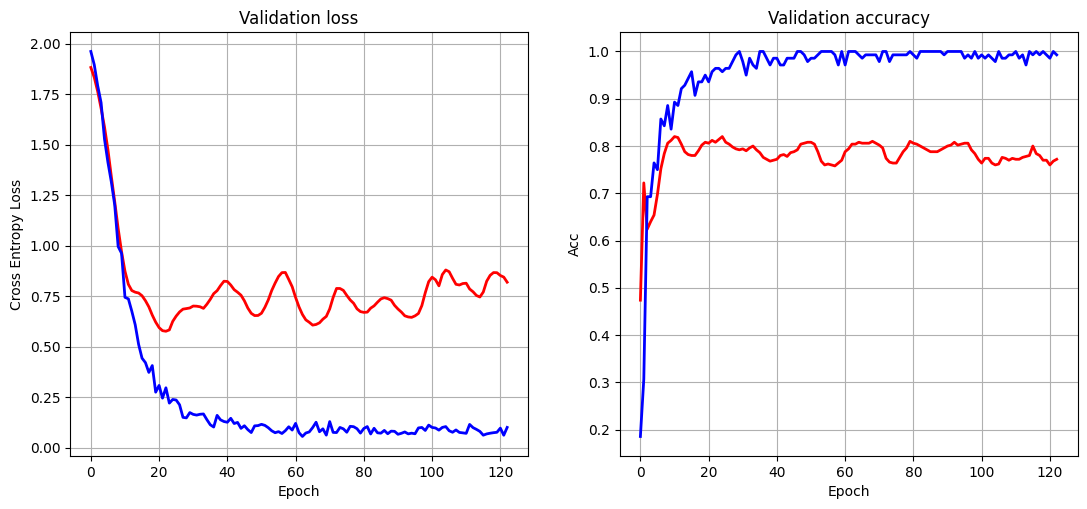

In [16]:
f, axs = plt.subplots(1, 2, figsize=(13, 5.5))
axs[0].plot(validation_loss, linewidth=2, color="red")
axs[0].plot(training_loss, linewidth=2, color="blue")
axs[0].set_title("Validation loss")
axs[0].set_ylabel("Cross Entropy Loss")
axs[0].set_xlabel("Epoch")
axs[0].grid()

# GPU „ÉÜ„É≥„ÇΩ„É´„ÇíCPU„Å´ÁßªÂãï„Åó„Å¶„Åã„Çânumpy„Å´Â§âÊèõ
validation_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in validation_acc]
training_acc_cpu = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in training_acc]

axs[1].plot(validation_acc_cpu, linewidth=2, color="red")
axs[1].plot(training_acc_cpu, linewidth=2, color="blue")
axs[1].set_title("Validation accuracy")
axs[1].set_ylabel("Acc")
axs[1].set_xlabel("Epoch")
axs[1].grid()

plt.show()

In [ ]:
# „Éë„É©„É°„Éº„ÇøËá™ÂãïË™øÊï¥„Ç∑„Çπ„ÉÜ„É†ÔºàÊîπËâØÁâàÔºâ

import itertools
import copy

def robust_seed_everything(seed: int = 42):
    """
    GPUÊé•Á∂öÁä∂ÊÖã„Å´Èñ¢‰øÇ„Å™„ÅèÂÆâÂÆö„Åó„Åü‰π±Êï∞Âõ∫ÂÆö„ÇíË°å„ÅÜÈñ¢Êï∞
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # PyTorch„ÅÆ‰π±Êï∞Âõ∫ÂÆö
    torch.manual_seed(seed)
    
    # GPUÂà©Áî®ÂèØËÉΩÊôÇ„ÅÆ„ÅøCUDA‰π±Êï∞„ÇíË®≠ÂÆö
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        # cudnn„ÅÆË®≠ÂÆö„ÇíÂº∑Âà∂ÁöÑ„Å´Âõ∫ÂÆö
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # GPUÁä∂ÊÖã„ÅÆÂêåÊúü„ÇíÂº∑Âà∂
        torch.cuda.synchronize()

def train_and_evaluate_model(alpha, K, hidden_dim, dropout, lr, weight_decay, features, labels, adj, train_set, validation_set, test_set):
    """
    ÊåáÂÆö„Åï„Çå„Åü„Éë„É©„É°„Éº„Çø„Åß„É¢„Éá„É´„ÇíË®ìÁ∑¥„Åó„ÄÅ„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶„ÇíËøî„ÅôÔºàÊîπËâØÁâàÔºâ
    """
    
    # ÊîπËâØ„Åï„Çå„Åü‰π±Êï∞Âõ∫ÂÆö
    robust_seed_everything(42)
    
    # „É¢„Éá„É´‰ΩúÊàê
    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=hidden_dim,
                    num_classes=num_classes,
                    K=K,
                    alpha=alpha,
                    dropout=dropout)
    
    # GPU„Å´ÁßªÂãïÔºàGPUÁä∂ÊÖã„ÉÅ„Çß„ÉÉ„ÇØ‰ªò„ÅçÔºâ
    if torch.cuda.is_available():
        model.cuda()
        # GPUÁßªÂãïÂæå„ÅÆ‰π±Êï∞Âõ∫ÂÆö„ÇíÂÜçÂÆüË°å
        torch.cuda.manual_seed_all(42)
    
    # „Ç™„Éó„ÉÜ„Ç£„Éû„Ç§„Ç∂„ÉºË®≠ÂÆö
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Early stoppingË®≠ÂÆö
    use_early_stopping = True
    patience = 100
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False
    
    # Ë®ìÁ∑¥„É´„Éº„Éó
    maxepoch = 1000
    for epoch in range(maxepoch):
        optimizer.zero_grad()
        model.train()
        
        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()
        
        # „Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ë©ï‰æ°
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
            
            if use_early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        stopped_early = True
                        break
    
    # „ÉÜ„Çπ„ÉàË©ï‰æ°
    with torch.no_grad():
        model.eval()
        y_pred = model(features, adj)
        test_loss = criterion(y_pred[test_set], labels[test_set])
        test_acc = accuracy(y_pred[test_set], labels[test_set])
    
    return test_acc.item(), epoch + 1  # ÂÆüÈöõ„ÅÆ„Ç®„Éù„ÉÉ„ÇØÊï∞„ÇÇËøî„Åô


Â≠¶ÁøíÂæå„ÅÆfeature„Åå„É©„Éô„É´„Åî„Å®„Å´„Åã„Åü„Åæ„Å£„Å¶„ÅÑ„ÇãË¶ã„Å¶„Åø„Åæ„Åó„Çá„ÅÜÔºé
„Åì„Åì„Åß„ÅØÔºåtSNE„ÇíÁî®„ÅÑ„Å¶Â§öÊ¨°ÂÖÉ„Éá„Éº„Çø„Çí2Ê¨°ÂÖÉ„Å´ËêΩ„Å®„ÅóËæº„Çì„ÅßÂèØË¶ñÂåñ„Çí„Åó„Åæ„ÅôÔºé

In [17]:
# „Éë„É©„É°„Éº„ÇøËá™ÂãïË™øÊï¥„Ç∑„Çπ„ÉÜ„É†

import itertools
import copy

def train_and_evaluate_model(alpha, K, hidden_dim, dropout, lr, weight_decay, features, labels, adj, train_set, validation_set, test_set):
    """
    ÊåáÂÆö„Åï„Çå„Åü„Éë„É©„É°„Éº„Çø„Åß„É¢„Éá„É´„ÇíË®ìÁ∑¥„Åó„ÄÅ„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶„ÇíËøî„Åô
    """

    # ‰π±Êï∞„Ç∑„Éº„Éâ„ÇíÂõ∫ÂÆö„Åó„Å¶ÂÜçÁèæÊÄß„Çí‰øù„Å§
    seed_everything(42)

    # „É¢„Éá„É´‰ΩúÊàê
    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=hidden_dim,
                    num_classes=num_classes,
                    K=K,
                    alpha=alpha,
                    dropout=dropout)

    # GPU„Å´ÁßªÂãï
    if torch.cuda.is_available():
        model.cuda()

    # „Ç™„Éó„ÉÜ„Ç£„Éû„Ç§„Ç∂„ÉºË®≠ÂÆö
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Early stoppingË®≠ÂÆö
    use_early_stopping = True
    patience = 100
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False

    # Ë®ìÁ∑¥„É´„Éº„Éó
    maxepoch = 1000
    for epoch in range(maxepoch):
        optimizer.zero_grad()
        model.train()

        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()

        # „Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ë©ï‰æ°
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])

            if use_early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        stopped_early = True
                        break

    # „ÉÜ„Çπ„ÉàË©ï‰æ°
    with torch.no_grad():
        model.eval()
        y_pred = model(features, adj)
        test_loss = criterion(y_pred[test_set], labels[test_set])
        test_acc = accuracy(y_pred[test_set], labels[test_set])

    return test_acc.item(), epoch + 1  # ÂÆüÈöõ„ÅÆ„Ç®„Éù„ÉÉ„ÇØÊï∞„ÇÇËøî„Åô

param_grid = {
    'alpha': [0.06],         # 0.1„ÅØÂ§ñ„Åô
    'K': [14],                       # 10„ÅØÂ§ñ„Åô
    'hidden_dim': [96],          # 64„ÅØÂ§ñ„Åô
    'dropout': [0.45],              # 0.5„ÅØÂ§ñ„Åô
    'lr': [0.009],        # 0.01„ÅØÂ§ñ„Åô
    'weight_decay': [3e-4]   # 5e-4„ÅØÂ§ñ„Åô
}

print("„Éë„É©„É°„Éº„ÇøËá™ÂãïË™øÊï¥„ÇíÈñãÂßã„Åó„Åæ„Åô...")
print(f"Á∑èÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: {len(param_grid['alpha']) * len(param_grid['K']) * len(param_grid['hidden_dim']) * len(param_grid['dropout']) * len(param_grid['lr']) * len(param_grid['weight_decay'])}")


„Éë„É©„É°„Éº„ÇøËá™ÂãïË™øÊï¥„ÇíÈñãÂßã„Åó„Åæ„Åô...
Á∑èÁµÑ„ÅøÂêà„Çè„ÅõÊï∞: 1


In [18]:
# „Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅÂÆüË°å
import time

def grid_search_optimization():
    """
    „Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅ„Åß„Éë„É©„É°„Éº„ÇøÊúÄÈÅ©Âåñ„ÇíÂÆüË°å
    """

    best_acc = 0.0
    best_params = None
    results = []

    # ÂÖ®ÁµÑ„ÅøÂêà„Çè„Åõ„ÇíÁîüÊàê
    param_combinations = list(itertools.product(
        param_grid['alpha'],
        param_grid['K'],
        param_grid['hidden_dim'],
        param_grid['dropout'],
        param_grid['lr'],
        param_grid['weight_decay']
    ))

    total_combinations = len(param_combinations)
    print(f"ÂêàË®à {total_combinations} ÂÄã„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Çí„ÉÜ„Çπ„Éà„Åó„Åæ„Åô")

    start_time = time.time()

    for i, (alpha, K, hidden_dim, dropout, lr, weight_decay) in enumerate(param_combinations):
        print(f"\nÈÄ≤Êçó: {i+1}/{total_combinations}")
        print(f"„ÉÜ„Çπ„Éà‰∏≠„ÅÆ„Éë„É©„É°„Éº„Çø: alpha={alpha}, K={K}, hidden_dim={hidden_dim}, dropout={dropout}, lr={lr}, weight_decay={weight_decay}")

        try:
            # „É¢„Éá„É´Ë®ìÁ∑¥„ÉªË©ï‰æ°
            test_acc, epochs = train_and_evaluate_model(
                alpha, K, hidden_dim, dropout, lr, weight_decay,
                features, labels, adj, train_set, validation_set, test_set
            )

            print(f"„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: {test_acc:.4f} („Ç®„Éù„ÉÉ„ÇØÊï∞: {epochs})")

            # ÁµêÊûú„ÇíË®òÈå≤
            result = {
                'alpha': alpha,
                'K': K,
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'lr': lr,
                'weight_decay': weight_decay,
                'test_acc': test_acc,
                'epochs': epochs
            }
            results.append(result)

            # „Éô„Çπ„ÉàÁµêÊûúÊõ¥Êñ∞
            if test_acc > best_acc:
                best_acc = test_acc
                best_params = result.copy()
                print(f"üéâ Êñ∞„Åó„ÅÑÊúÄÈ´òÁ≤æÂ∫¶! {best_acc:.4f}")

        except Exception as e:
            print(f"„Ç®„É©„ÉºÁô∫Áîü: {e}")
            continue

        # ÈÄ≤ÊçóÊôÇÈñìË°®Á§∫
        elapsed = time.time() - start_time
        avg_time = elapsed / (i + 1)
        remaining = avg_time * (total_combinations - i - 1)
        print(f"ÁµåÈÅéÊôÇÈñì: {elapsed/60:.1f}ÂàÜ, Êé®ÂÆöÊÆã„ÇäÊôÇÈñì: {remaining/60:.1f}ÂàÜ")

    return best_params, best_acc, results

# ÊúÄÈÅ©ÂåñÂÆüË°å
print("„Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅÊúÄÈÅ©Âåñ„ÇíÈñãÂßã„Åó„Åæ„Åô...")
best_params, best_acc, all_results = grid_search_optimization()

print(f"\nüèÜ ÊúÄÈÅ©ÂåñÂÆå‰∫Ü!")
print(f"ÊúÄÈ´ò„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: {best_acc:.4f}")
print("ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


„Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅÊúÄÈÅ©Âåñ„ÇíÈñãÂßã„Åó„Åæ„Åô...
ÂêàË®à 1 ÂÄã„ÅÆÁµÑ„ÅøÂêà„Çè„Åõ„Çí„ÉÜ„Çπ„Éà„Åó„Åæ„Åô

ÈÄ≤Êçó: 1/1
„ÉÜ„Çπ„Éà‰∏≠„ÅÆ„Éë„É©„É°„Éº„Çø: alpha=0.06, K=14, hidden_dim=96, dropout=0.45, lr=0.009, weight_decay=0.0003
„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: 0.7650 („Ç®„Éù„ÉÉ„ÇØÊï∞: 119)
üéâ Êñ∞„Åó„ÅÑÊúÄÈ´òÁ≤æÂ∫¶! 0.7650
ÁµåÈÅéÊôÇÈñì: 0.0ÂàÜ, Êé®ÂÆöÊÆã„ÇäÊôÇÈñì: 0.0ÂàÜ

üèÜ ÊúÄÈÅ©ÂåñÂÆå‰∫Ü!
ÊúÄÈ´ò„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: 0.7650
ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003
  test_acc: 0.765
  epochs: 119


In [19]:
# ÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê„Å®ÂèØË¶ñÂåñ

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(results):
    """
    „Ç∞„É™„ÉÉ„Éâ„Çµ„Éº„ÉÅÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê
    """

    # DataFrame„Å´Â§âÊèõ
    df = pd.DataFrame(results)

    print("üìä ÁµêÊûúÁµ±Ë®à:")
    print(f"Âπ≥Âùá„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: {df['test_acc'].mean():.4f}")
    print(f"Ê®ôÊ∫ñÂÅèÂ∑Æ: {df['test_acc'].std():.4f}")
    print(f"ÊúÄÈ´òÁ≤æÂ∫¶: {df['test_acc'].max():.4f}")
    print(f"ÊúÄ‰ΩéÁ≤æÂ∫¶: {df['test_acc'].min():.4f}")

    # ‰∏ä‰Ωç10ÁµêÊûú„ÇíË°®Á§∫
    print("\nüèÜ ‰∏ä‰Ωç10ÁµêÊûú:")
    top_results = df.nlargest(10, 'test_acc')
    for i, row in top_results.iterrows():
        print(f"{len(top_results) - list(top_results.index).index(i)}‰Ωç: Á≤æÂ∫¶ {row['test_acc']:.4f} | "
              f"alpha={row['alpha']}, K={row['K']}, hidden_dim={row['hidden_dim']}, "
              f"dropout={row['dropout']}, lr={row['lr']}, weight_decay={row['weight_decay']}")

    # ÂêÑ„Éë„É©„É°„Éº„Çø„ÅÆÂΩ±Èüø„ÇíÂàÜÊûê
    print("\nüìà „Éë„É©„É°„Éº„ÇøÂà•Âπ≥ÂùáÁ≤æÂ∫¶:")
    for param in ['alpha', 'K', 'hidden_dim', 'dropout', 'lr', 'weight_decay']:
        param_analysis = df.groupby(param)['test_acc'].agg(['mean', 'std', 'count'])
        print(f"\n{param}:")
        for value, stats in param_analysis.iterrows():
            print(f"  {value}: Âπ≥Âùá {stats['mean']:.4f} ¬± {stats['std']:.4f} (n={stats['count']})")

    return df, top_results

# ÁµêÊûúÂàÜÊûêÂÆüË°å
print("ÁµêÊûúÂàÜÊûê„ÇíÈñãÂßã„Åó„Åæ„Åô...")
results_df, top_10 = analyze_results(all_results)


ÁµêÊûúÂàÜÊûê„ÇíÈñãÂßã„Åó„Åæ„Åô...
üìä ÁµêÊûúÁµ±Ë®à:
Âπ≥Âùá„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: 0.7650
Ê®ôÊ∫ñÂÅèÂ∑Æ: nan
ÊúÄÈ´òÁ≤æÂ∫¶: 0.7650
ÊúÄ‰ΩéÁ≤æÂ∫¶: 0.7650

üèÜ ‰∏ä‰Ωç10ÁµêÊûú:
1‰Ωç: Á≤æÂ∫¶ 0.7650 | alpha=0.06, K=14.0, hidden_dim=96.0, dropout=0.45, lr=0.009, weight_decay=0.0003

üìà „Éë„É©„É°„Éº„ÇøÂà•Âπ≥ÂùáÁ≤æÂ∫¶:

alpha:
  0.06: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)

K:
  14: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)

hidden_dim:
  96: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)

dropout:
  0.45: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)

lr:
  0.009: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)

weight_decay:
  0.0003: Âπ≥Âùá 0.7650 ¬± nan (n=1.0)


In [20]:
# ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„ÅÆÊúÄÁµÇÊ§úË®º

def final_validation_with_best_params(best_params):
    """
    ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„É¢„Éá„É´„ÇíÂÜçË®ìÁ∑¥„Åó„ÄÅË©≥Á¥∞„Å™ÁµêÊûú„ÇíÂèñÂæó
    """

    print("üîç ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„ÅÆÊúÄÁµÇÊ§úË®º„ÇíÂÆüË°å„Åó„Åæ„Åô...")
    print("„Éë„É©„É°„Éº„Çø:")
    for key, value in best_params.items():
        if key not in ['test_acc', 'epochs']:
            print(f"  {key}: {value}")

    # ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„ÅßÂÜçÂ∫¶Ë®ìÁ∑¥
    seed_everything(42)  # ÂÜçÁèæÊÄßÁ¢∫‰øù

    model = APPNPNet(num_features=features.shape[1],
                    hidden_dim=best_params['hidden_dim'],
                    num_classes=num_classes,
                    K=best_params['K'],
                    alpha=best_params['alpha'],
                    dropout=best_params['dropout'])

    if torch.cuda.is_available():
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(),
                               lr=best_params['lr'],
                               weight_decay=best_params['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    # Ë®ìÁ∑¥ÈÅéÁ®ã„ÇíË®òÈå≤
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 100

    print("\nË®ìÁ∑¥ÈñãÂßã...")
    for epoch in range(1000):
        # Ë®ìÁ∑¥
        optimizer.zero_grad()
        model.train()
        y_pred = model(features, adj)
        train_loss = criterion(y_pred[train_set], labels[train_set])
        train_acc = accuracy(y_pred[train_set], labels[train_set])
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())

        # „Éê„É™„Éá„Éº„Ç∑„Éß„É≥
        with torch.no_grad():
            model.eval()
            y_pred_val = model(features, adj)
            val_loss = criterion(y_pred_val[validation_set], labels[validation_set])
            val_acc = accuracy(y_pred_val[validation_set], labels[validation_set])

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # ÊúÄÁµÇ„ÉÜ„Çπ„Éà
    with torch.no_grad():
        model.eval()
        y_pred_final = model(features, adj)
        test_loss = criterion(y_pred_final[test_set], labels[test_set])
        test_acc = accuracy(y_pred_final[test_set], labels[test_set])

    print(f"\n‚úÖ ÊúÄÁµÇÁµêÊûú:")
    print(f"„ÉÜ„Çπ„ÉàÊêçÂ§±: {test_loss:.4f}")
    print(f"„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: {test_acc:.4f}")
    print(f"Ë®ìÁ∑¥„Ç®„Éù„ÉÉ„ÇØÊï∞: {epoch + 1}")

    return {
        'model': model,
        'test_acc': test_acc.item(),
        'test_loss': test_loss.item(),
        'epochs': epoch + 1,
        'train_history': {
            'loss': train_losses,
            'acc': train_accs
        },
        'val_history': {
            'loss': val_losses,
            'acc': val_accs
        }
    }

# ÊúÄÁµÇÊ§úË®ºÂÆüË°å
final_results = final_validation_with_best_params(best_params)

print(f"\nüéØ ÊúÄÁµÇÁöÑ„Å™ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Å®„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶:")
print(f"„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: {final_results['test_acc']:.4f}")
print("ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø:")
for key, value in best_params.items():
    if key not in ['test_acc', 'epochs']:
        print(f"  {key}: {value}")


üîç ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„ÅÆÊúÄÁµÇÊ§úË®º„ÇíÂÆüË°å„Åó„Åæ„Åô...
„Éë„É©„É°„Éº„Çø:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003

Ë®ìÁ∑¥ÈñãÂßã...
Epoch 0: Train Loss=1.9468, Train Acc=0.1714, Val Loss=1.8999, Val Acc=0.2020
Epoch 50: Train Loss=0.0904, Train Acc=0.9857, Val Loss=0.7250, Val Acc=0.7940
Epoch 100: Train Loss=0.1730, Train Acc=0.9786, Val Loss=1.0115, Val Acc=0.7440

‚úÖ ÊúÄÁµÇÁµêÊûú:
„ÉÜ„Çπ„ÉàÊêçÂ§±: 0.8220
„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: 0.7650
Ë®ìÁ∑¥„Ç®„Éù„ÉÉ„ÇØÊï∞: 119

üéØ ÊúÄÁµÇÁöÑ„Å™ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Å®„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶:
„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶: 0.7650
ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø:
  alpha: 0.06
  K: 14
  hidden_dim: 96
  dropout: 0.45
  lr: 0.009
  weight_decay: 0.0003


<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-4aec64034fd6>:63: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from font(s) DejaVu Sans.
  plt.tigh

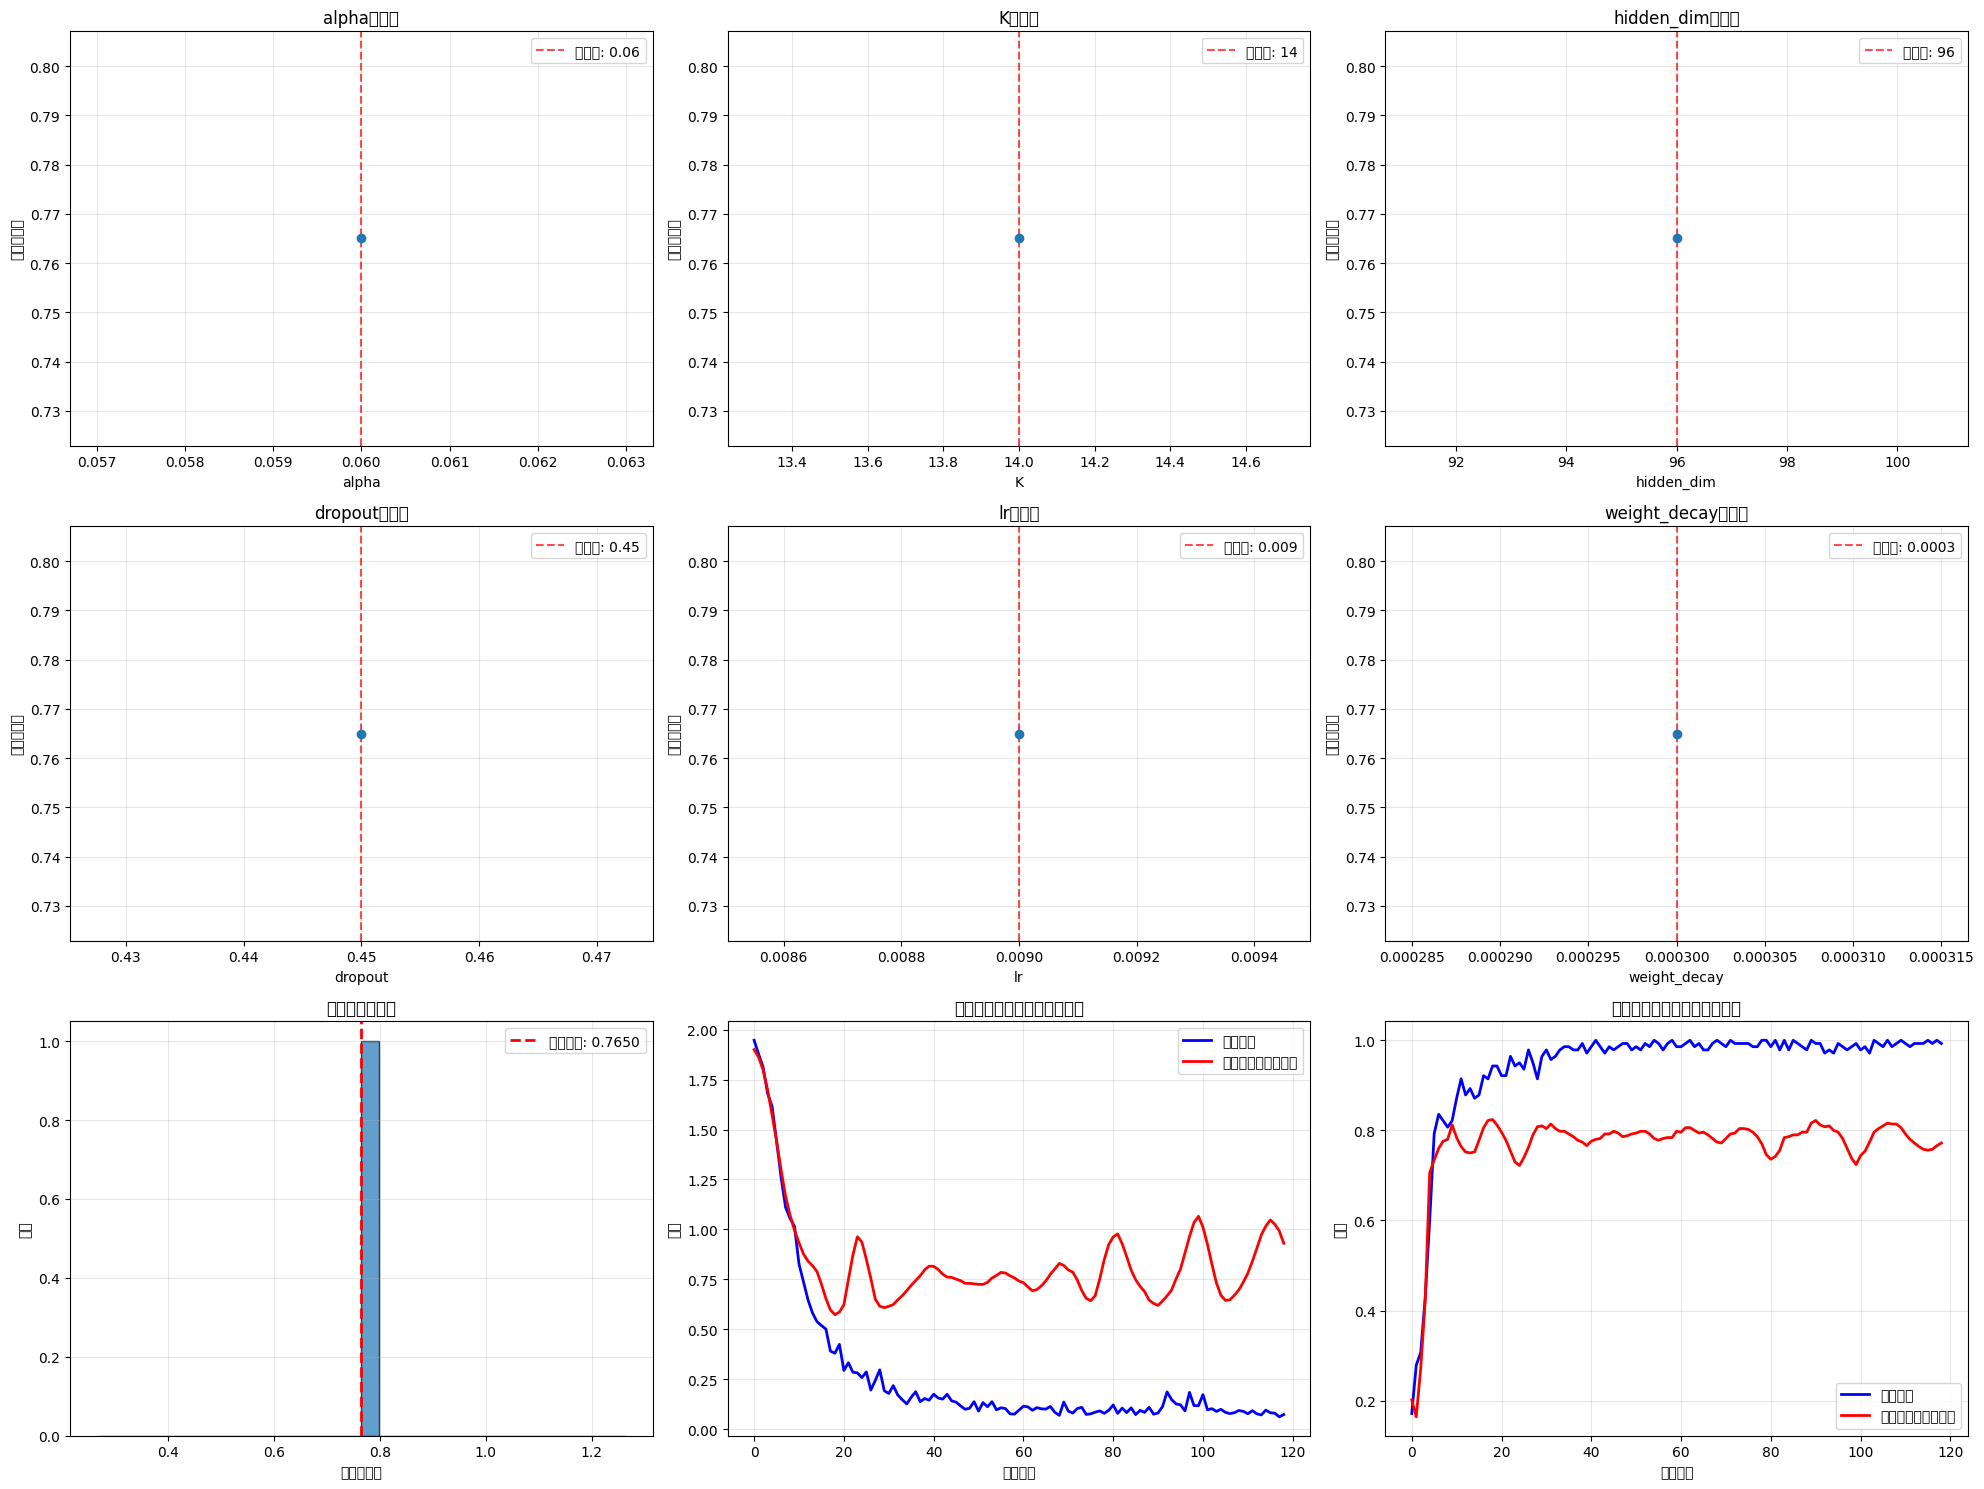

ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü: /content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv


In [21]:
# ÁµêÊûú„ÅÆÂèØË¶ñÂåñ

def plot_optimization_results(results_df, final_results):
    """
    ÊúÄÈÅ©ÂåñÁµêÊûú„ÅÆÂèØË¶ñÂåñ
    """

    plt.figure(figsize=(20, 15))

    # 1. „Éë„É©„É°„Éº„ÇøÂà•Á≤æÂ∫¶ÂàÜÂ∏É
    params_to_plot = ['alpha', 'K', 'hidden_dim', 'dropout', 'lr', 'weight_decay']

    for i, param in enumerate(params_to_plot, 1):
        plt.subplot(3, 3, i)
        param_groups = results_df.groupby(param)['test_acc'].agg(['mean', 'std'])

        x = param_groups.index
        y = param_groups['mean']
        yerr = param_groups['std']

        plt.errorbar(x, y, yerr=yerr, marker='o', capsize=3, capthick=2)
        plt.title(f'{param}„ÅÆÂΩ±Èüø')
        plt.xlabel(param)
        plt.ylabel('„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶')
        plt.grid(True, alpha=0.3)

        # ÊúÄÈÅ©ÂÄ§„Çí„Éè„Ç§„É©„Ç§„Éà
        if param in best_params:
            best_val = best_params[param]
            plt.axvline(x=best_val, color='red', linestyle='--', alpha=0.7, label=f'ÊúÄÈÅ©ÂÄ§: {best_val}')
            plt.legend()

    # 2. Á≤æÂ∫¶ÂàÜÂ∏É„Éí„Çπ„Éà„Ç∞„É©„É†
    plt.subplot(3, 3, 7)
    plt.hist(results_df['test_acc'], bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=final_results['test_acc'], color='red', linestyle='--', linewidth=2, label=f'ÊúÄÈ´òÁ≤æÂ∫¶: {final_results["test_acc"]:.4f}')
    plt.title('„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶ÂàÜÂ∏É')
    plt.xlabel('„ÉÜ„Çπ„ÉàÁ≤æÂ∫¶')
    plt.ylabel('È†ªÂ∫¶')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Ë®ìÁªÉËøáÁ®ãÂèØËßÜÂåñ
    plt.subplot(3, 3, 8)
    epochs_range = range(len(final_results['train_history']['loss']))
    plt.plot(epochs_range, final_results['train_history']['loss'], 'b-', label='Ë®ìÁ∑¥ÊêçÂ§±', linewidth=2)
    plt.plot(epochs_range, final_results['val_history']['loss'], 'r-', label='„Éê„É™„Éá„Éº„Ç∑„Éß„É≥ÊêçÂ§±', linewidth=2)
    plt.title('ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„ÅÆÊêçÂ§±Â§âÂåñ')
    plt.xlabel('„Ç®„Éù„ÉÉ„ÇØ')
    plt.ylabel('ÊêçÂ§±')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 3, 9)
    plt.plot(epochs_range, final_results['train_history']['acc'], 'b-', label='Ë®ìÁ∑¥Á≤æÂ∫¶', linewidth=2)
    plt.plot(epochs_range, final_results['val_history']['acc'], 'r-', label='„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Á≤æÂ∫¶', linewidth=2)
    plt.title('ÊúÄÈÅ©„Éë„É©„É°„Éº„Çø„Åß„ÅÆÁ≤æÂ∫¶Â§âÂåñ')
    plt.xlabel('„Ç®„Éù„ÉÉ„ÇØ')
    plt.ylabel('Á≤æÂ∫¶')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ÂèØË¶ñÂåñÂÆüË°å
plot_optimization_results(results_df, final_results)

# ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò
results_df.to_csv('/content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv', index=False)
print("ÁµêÊûú„ÇíCSV„Éï„Ç°„Ç§„É´„Å´‰øùÂ≠ò„Åó„Åæ„Åó„Åü: /content/drive/My Drive/Colab Notebooks/appnp_optimization_results.csv")


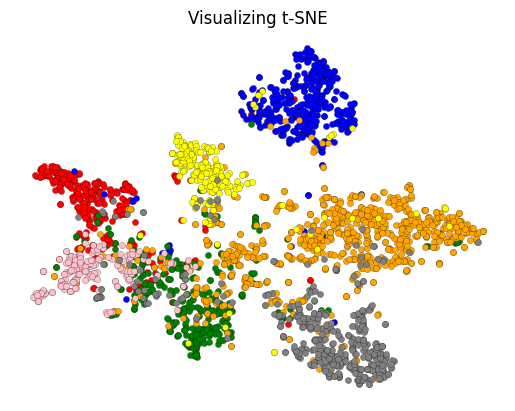

In [22]:
visualize_embedding_tSNE(labels, y_pred, num_classes)